<a href="https://colab.research.google.com/github/raquelvargas16/MIAR-Python-Activities/blob/develop/Actividad_C1_P1_Raquel_Vargas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

In [96]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [97]:
cd /content/drive/MyDrive/MIAR - Aprendizaje Supervisado/Actividad_C1_P1

/content/drive/MyDrive/MIAR - Aprendizaje Supervisado/Actividad_C1_P1


In [98]:
import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes as bfh
from skimage.morphology import convex_hull_image
from skimage.measure import regionprops
from skimage.measure import label
from tabulate import tabulate
import math
import numpy as np
import skimage as ski
import cv2
import os

(1024, 1024, 3)


(<matplotlib.image.AxesImage at 0x7b90ee1ef190>,
 Text(0.5, 1.0, 'Histologia 2'))

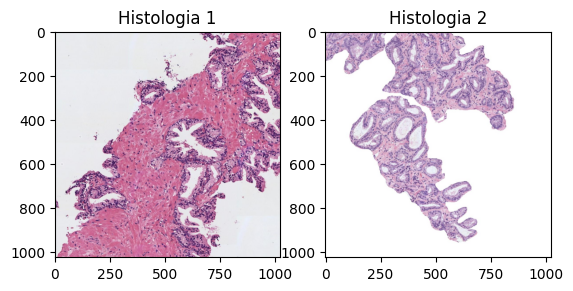

In [99]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
histo_1 = ski.io.imread('histo_1.jpg')
histo_2 = ski.io.imread('histo_2.jpg')
print(histo_1.shape)

# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
histo_1_copy = histo_1.copy()
histo_2_copy = histo_2.copy()
histo_1_norm = histo_1_copy.astype('uint8') / 1023
histo_2_norm = histo_2_copy.astype('uint8') / 1023

# Visualizar la imagen
fig, ax = plt.subplots(1, 2)
ax[0].imshow(histo_1, cmap='gray'), ax[0].set_title('Histologia 1')
ax[1].imshow(histo_2, cmap='gray'), ax[1].set_title('Histologia 2')

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

(<matplotlib.image.AxesImage at 0x7b90fe08e650>,
 Text(0.5, 1.0, 'Canal Magenta de Histologia 2'))

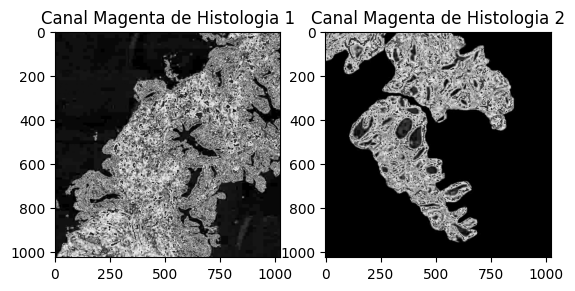

In [100]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
with np.errstate(invalid='ignore', divide='ignore'):
    histo_1_K = 1 - np.max(histo_1_norm, axis=2)
    histo_1_C = (1 - histo_1_norm[:,:,2] - histo_1_K) / (1 - histo_1_K)
    histo_1_M = (1 - histo_1_norm[:,:,1] - histo_1_K) / (1 - histo_1_K)
    histo_1_Y = (1 - histo_1_norm[:,:,0] - histo_1_K) / (1 - histo_1_K)
histo_1_CMYK = (np.dstack((histo_1_C,
                           histo_1_M,
                           histo_1_Y,
                           histo_1_K))*1023).astype('uint8')
histo_1_C, histo_1_M, histo_1_Y, histo_1_K = cv2.split(histo_1_CMYK)

with np.errstate(invalid='ignore', divide='ignore'):
    histo_2_K = 1 - np.max(histo_2_norm, axis=2)
    histo_2_C = (1 - histo_2_norm[:,:,2] - histo_2_K) / (1 - histo_2_K)
    histo_2_M = (1 - histo_2_norm[:,:,1] - histo_2_K) / (1 - histo_2_K)
    histo_2_Y = (1 - histo_2_norm[:,:,0] - histo_2_K) / (1 - histo_2_K)
histo_2_CMYK = (np.dstack((histo_2_C,
                           histo_2_M,
                           histo_2_Y,
                           histo_2_K))*1023).astype('uint8')
histo_2_C, histo_2_M, histo_2_Y, histo_2_K = cv2.split(histo_2_CMYK)

# Visualizar la imagen del canal magenta
fig, ax = plt.subplots(1, 2)
ax[0].imshow(histo_1_M, cmap='gray'), ax[0].set_title('Canal Magenta de Histologia 1')
ax[1].imshow(histo_2_M, cmap='gray'), ax[1].set_title('Canal Magenta de Histologia 2')

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

[0 1]


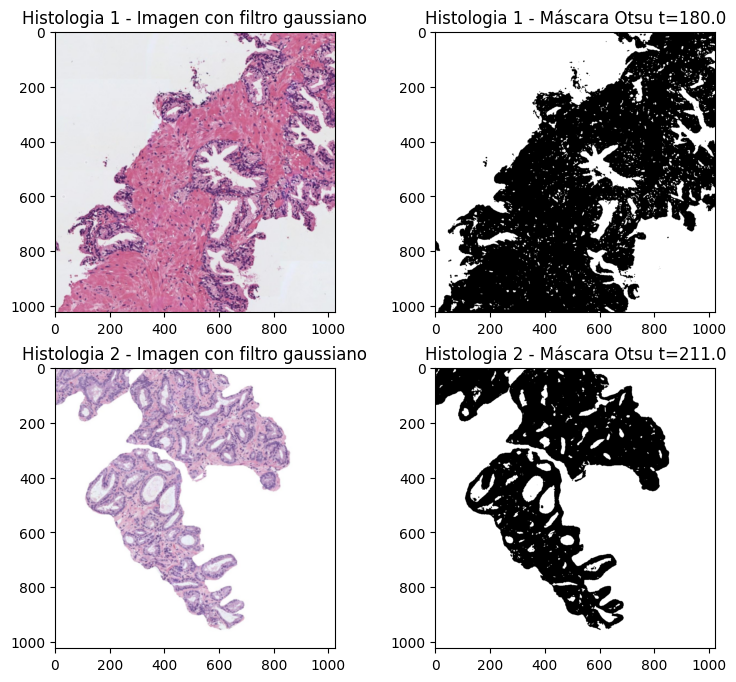

In [101]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".

# Filtro gaussiano
histo_1_gauss = cv2.GaussianBlur(histo_1, (5, 5), 0)
histo_1_gauss_grayscale = cv2.cvtColor(histo_1_gauss, cv2.COLOR_BGR2GRAY)
histo_2_gauss = cv2.GaussianBlur(histo_2, (5, 5), 0)
histo_2_gauss_grayscale = cv2.cvtColor(histo_2_gauss, cv2.COLOR_BGR2GRAY)
# Método de Otsu
histo_1_t, histo_1_mask = cv2.threshold(histo_1_gauss_grayscale.astype('uint8'),
                        0,
                        1,
                        cv2.THRESH_OTSU)
histo_2_t, histo_2_mask = cv2.threshold(histo_2_gauss_grayscale.astype('uint8'),
                        0,
                        1,
                        cv2.THRESH_OTSU)
print(np.unique(histo_1_mask))

# Visualizar la máscara resultante
fig, ax = plt.subplots(2, 2, figsize=(9, 8))
ax[0][0].imshow(histo_1_gauss, cmap='gray'), ax[0][0].set_title('Histologia 1 - Imagen con filtro gaussiano')
ax[0][1].imshow(histo_1_mask, cmap='gray'), ax[0][1].set_title('Histologia 1 - Máscara Otsu t=' + str(histo_1_t))
ax[1][0].imshow(histo_2_gauss, cmap='gray'), ax[1][0].set_title('Histologia 2 - Imagen con filtro gaussiano')
ax[1][1].imshow(histo_2_mask, cmap='gray'), ax[1][1].set_title('Histologia 2 - Máscara Otsu t=' + str(histo_2_t))
plt.show()

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

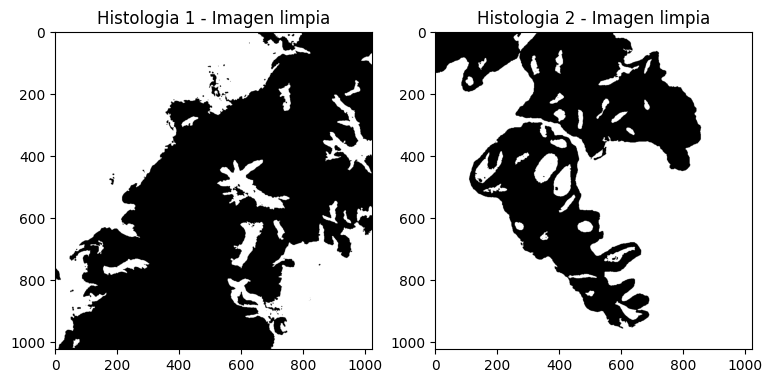

In [102]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
histo_1_mask_cleaned = ski.morphology.remove_small_objects(histo_1_mask.astype(bool), 300)
histo_2_mask_cleaned = ski.morphology.remove_small_objects(histo_2_mask.astype(bool), 300)

# Visualizar la máscara resultante
fig, ax = plt.subplots(1, 2, figsize=(9, 8))
ax[0].imshow(histo_1_mask_cleaned, cmap='gray'), ax[0].set_title('Histologia 1 - Imagen limpia')
ax[1].imshow(histo_2_mask_cleaned, cmap='gray'), ax[1].set_title('Histologia 2 - Imagen limpia')
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

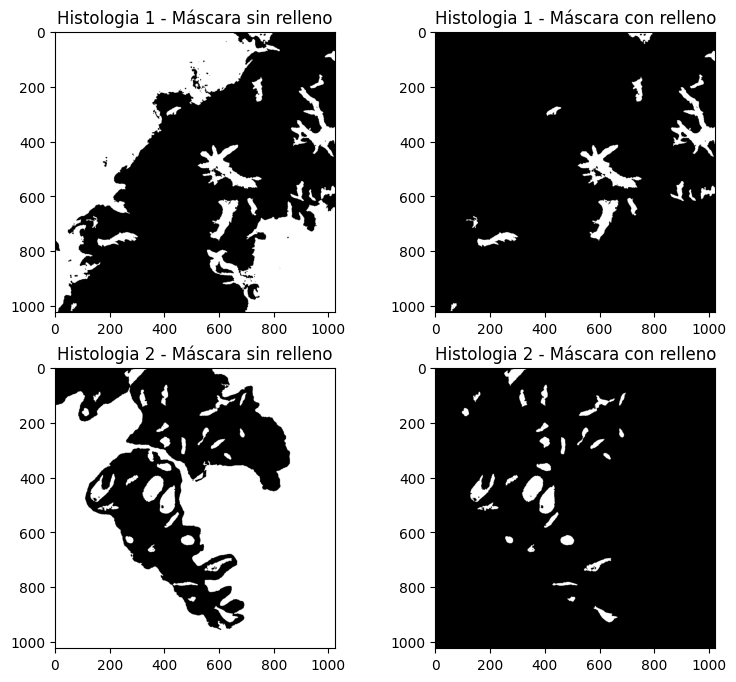

In [103]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.

histo_1_mask_cleaned_filled = histo_1_mask_cleaned.astype('uint8').copy()
# Definir una imagen negra de referencia
h, w = histo_1_mask_cleaned_filled.shape
ref = np.zeros((h + 2, w + 2), np.uint8)
cv2.floodFill(histo_1_mask_cleaned_filled, ref, (0, 0), 0)
cv2.floodFill(histo_1_mask_cleaned_filled, ref, (1000, 1000), 0)

histo_2_mask_cleaned_filled = histo_2_mask_cleaned.astype('uint8').copy()
cv2.floodFill(histo_2_mask_cleaned_filled, None, (650, 500), 0)

# Visualizar la máscara resultante.
fig, ax = plt.subplots(2, 2, figsize=(9, 8))
ax[0][0].imshow(histo_1_mask_cleaned, cmap='gray'), ax[0][0].set_title('Histologia 1 - Máscara sin relleno')
ax[0][1].imshow(histo_1_mask_cleaned_filled, cmap='gray'), ax[0][1].set_title('Histologia 1 - Máscara con relleno')
ax[1][0].imshow(histo_2_mask_cleaned, cmap='gray'), ax[1][0].set_title('Histologia 2 - Máscara sin relleno')
ax[1][1].imshow(histo_2_mask_cleaned_filled, cmap='gray'), ax[1][1].set_title('Histologia 2 - Máscara con relleno')
plt.show()

#### 5) Rellenar los objetos de los lúmenes

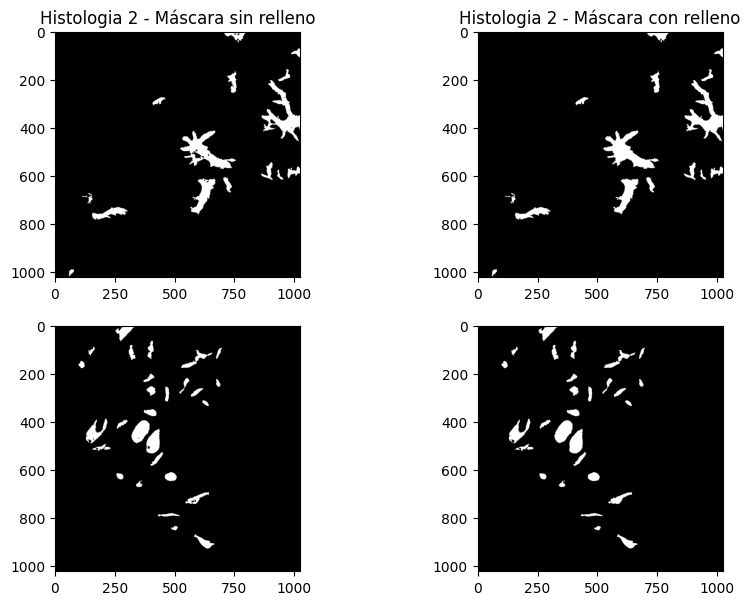

In [104]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
histo_1_mask_cleaned_filled_holes = bfh(histo_1_mask_cleaned_filled)
histo_2_mask_cleaned_filled_holes = bfh(histo_2_mask_cleaned_filled)

# Visualizar la máscara resultante
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
ax[0][0].imshow(histo_1_mask_cleaned_filled, cmap='gray'), ax[0][0].set_title('Histologia 1 - Máscara sin relleno')
ax[0][1].imshow(histo_1_mask_cleaned_filled_holes, cmap='gray'), ax[0][1].set_title('Histologia 1 - Máscara con relleno')
ax[1][0].imshow(histo_2_mask_cleaned_filled, cmap='gray'), ax[0][0].set_title('Histologia 2 - Máscara sin relleno')
ax[1][1].imshow(histo_2_mask_cleaned_filled_holes, cmap='gray'), ax[0][1].set_title('Histologia 2 - Máscara con relleno')
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

número de objetos:  15
posibles valores de intensidad:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
número de objetos:  28
posibles valores de intensidad:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]


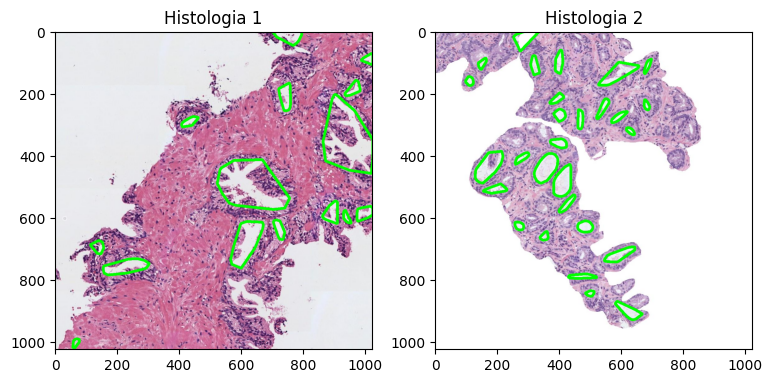

In [105]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles.
histo_1_lab, histo_1_num = label(histo_1_mask_cleaned_filled_holes, return_num=True)
print('número de objetos: ', histo_1_num)
v, c = np.unique(histo_1_lab, return_counts=True)
print('posibles valores de intensidad: ', v)
imagen_1 = histo_1.copy()
for i in range(1, histo_1_num+1):
    objeto = histo_1_lab == i
    objeto = objeto.astype('uint8')
    # covex hull
    convex_image = convex_hull_image(objeto)
    convex_image = convex_image.astype('uint8')
    conts,_ = cv2.findContours(convex_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    imagen_1 = cv2.drawContours(imagen_1, conts, -1, (0, 255, 0), 8)

histo_2_lab, histo_2_num = label(histo_2_mask_cleaned_filled_holes, return_num=True)
print('número de objetos: ', histo_2_num)
v, c = np.unique(histo_2_lab, return_counts=True)
print('posibles valores de intensidad: ', v)
imagen_2 = histo_2.copy()
for i in range(1, histo_2_num+1):
    objeto = histo_2_lab == i
    objeto = objeto.astype('uint8')
    # covex hull
    convex_image = convex_hull_image(objeto)
    convex_image = convex_image.astype('uint8')
    conts,_ = cv2.findContours(convex_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    imagen_2 = cv2.drawContours(imagen_2, conts, -1, (0, 255, 0), 8)

# Visualizar la imagen superpuesta
fig, ax = plt.subplots(1, 2, figsize=(9, 8))
ax[0].imshow(imagen_1, cmap='gray'), ax[0].set_title('Histologia 1')
ax[1].imshow(imagen_2, cmap='gray'), ax[1].set_title('Histologia 2')
plt.show()

#### 7) Identificar y cropear el lumen más grande

In [119]:
histo_1_areas_list = []
for i in range(1, histo_1_num + 1):
    objeto = histo_1_lab == i
    prop = regionprops(objeto.astype(np.uint8))
    histo_1_areas_list.append(prop[0].area)
hist_1_max_area = max(histo_1_areas_list)
hist_1_obj_max_area = histo_1_areas_list.index(hist_1_max_area) + 1
print("Area max.: ", hist_1_max_area)
print("Num. objeto: ", hist_1_obj_max_area)

Area max.:  13388
Num. objeto:  7


In [120]:
histo_2_areas_list = []
for i in range(1, histo_2_num + 1):
    objeto = histo_2_lab == i
    prop = regionprops(objeto.astype(np.uint8))
    histo_2_areas_list.append(prop[0].area)
hist_2_max_area = max(histo_2_areas_list)
hist_2_obj_max_area = histo_2_areas_list.index(hist_2_max_area) + 1
print("Area max.: ", hist_2_max_area)
print("Num. objeto: ", hist_2_obj_max_area)

Area max.:  4691
Num. objeto:  18


(<matplotlib.image.AxesImage at 0x7b91007587c0>,
 Text(0.5, 1.0, 'Histologia 2 - lumen mas grande'))

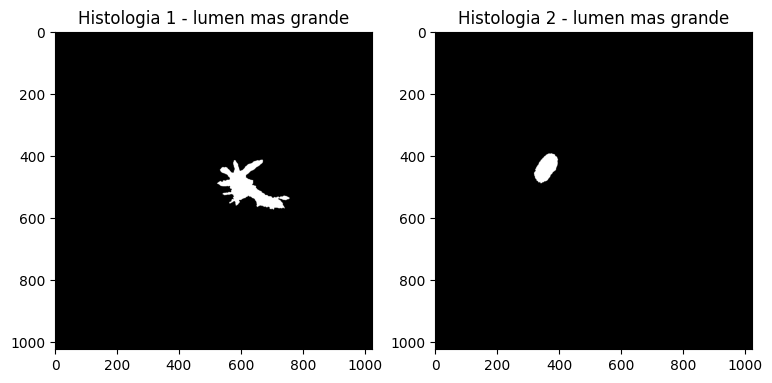

In [122]:
hist_1_obj = histo_1_lab == hist_1_obj_max_area
hist_2_obj = histo_2_lab == hist_2_obj_max_area
fig, ax = plt.subplots(1, 2, figsize = (9, 7))
ax[0].imshow(hist_1_obj, cmap='gray'), ax[0].set_title("Histologia 1 - lumen mas grande")
ax[1].imshow(hist_2_obj, cmap='gray'), ax[1].set_title("Histologia 2 - lumen mas grande")

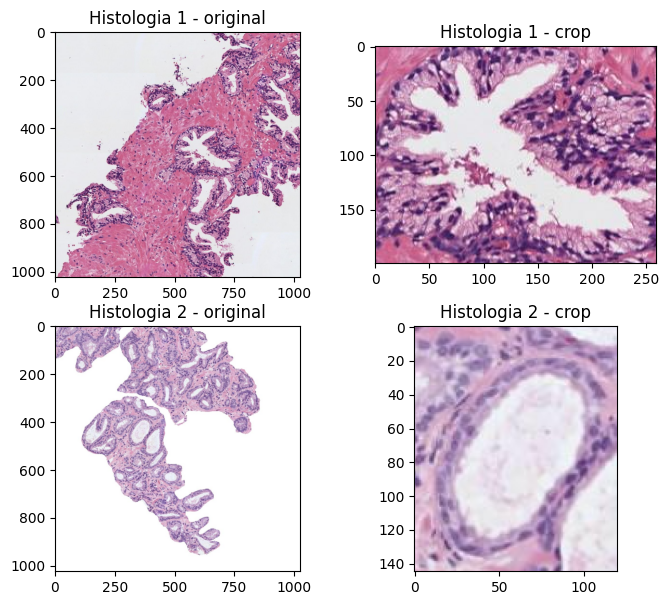

In [133]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
lumen_1 = histo_1[400:600, 500:760]
lumen_2 = histo_2[365:510, 295:415]
# Visualizar el lumen cropeado.
figs, ax = plt.subplots(2, 2, figsize=(8, 7))
ax[0][0].imshow(histo_1, cmap='gray'), ax[0][0].set_title('Histologia 1 - original')
ax[0][1].imshow(lumen_1, cmap='gray'), ax[0][1].set_title('Histologia 1 - crop')
ax[1][0].imshow(histo_2, cmap='gray'), ax[1][0].set_title('Histologia 2 - original')
ax[1][1].imshow(lumen_2, cmap='gray'), ax[1][1].set_title('Histologia 2 - crop')
plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado

In [134]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
headers = ['Histologia_1', 'Histologia_2']
A,BB,CA,E,ED,EX,FD, MA,MiA,OR,P,S,CO = (['area'],['bbox_area'], ['convex_area'], ['eccentricity'], ['equiv_diameter'],
['extent'], ['feret_diameter'], ['major_axis'], ['minor_axis'], ['orientation'], ['perimeter'], ['solidity'], ['compactness'])

for i in [hist_1_obj, hist_2_obj]:
    objeto = i
    prop = regionprops(objeto.astype(np.uint8))
    # 1) Área
    A.append(np.round(prop[0].area, 4))
    # 2) Área de la bounding box
    BB.append(np.round(prop[0].bbox_area, 4))
    # 3) Área convexa
    CA.append(np.round(prop[0].convex_area, 4))
    # 4) Exentricidad
    E.append(np.round(prop[0].eccentricity, 4))
    # 5) Diámetro equivalente
    ED.append(np.round(prop[0].equivalent_diameter, 4) )
    # 6) Extensión
    EX.append(np.round(prop[0].extent, 4))
    # 7) Diámetro Feret
    FD.append(np.round(prop[0].feret_diameter_max, 4))
    # 8) Longitud del eje mayor
    MA.append(np.round(prop[0].major_axis_length, 4))
    # 9) Longitud del eje menor
    MiA.append(np.round(prop[0].minor_axis_length, 4))
    # 10) Orientación
    OR.append(np.round(prop[0].orientation, 4))
    # 11) Perímetro
    P.append(np.round(prop[0].perimeter, 4))
    # 12) Solidez
    S.append(np.round(prop[0].solidity, 4))
    # 13) Compacidad
    CO.append(np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4))

metrics = [tuple(A), tuple(BB), tuple(CA),
           tuple(E), tuple(ED), tuple(EX),
           tuple(FD), tuple(MA), tuple(MiA),
           tuple(OR), tuple(P), tuple(S), tuple(CO)]
print(tabulate(metrics, headers=headers))

                  Histologia_1    Histologia_2
--------------  --------------  --------------
area                13388            4691
bbox_area           37674            7392
convex_area         27468            4885
eccentricity            0.8443          0.8372
equiv_diameter        130.561          77.2837
extent                  0.3554          0.6346
feret_diameter        243.463         104.317
major_axis            231.639         104.786
minor_axis            124.136          57.303
orientation             0.9969         -0.5628
perimeter            1163.63          288.149
solidity                0.4874          0.9603
compactness             0.1243          0.71
